In [1]:
import helper
import numpy as np
import os
import matplotlib.pyplot as plt

/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:144: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'A', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = windows.dot(grn)
/Users/csengepetak/Documents/GitHub/CA_GRN2/helper.py:165: NumbaPerformanceWarning: np.dot() is faster on contiguous arrays, called on (Array(float64, 2, 'C', False, aligned=True), Array(float64, 2, 'A', False, aligned=True))
  next_step = gene_vals.dot(internal_grn)


In [49]:
pop_size = 20
grn_size=22
dev_steps = 22
num_cells = 22
geneid=1
try_seedints = [69904,149796]

rule = 30

all_targs=[]
for s in try_seedints:
    random_grns=np.random.randn(5, grn_size+2, grn_size).astype(np.float64)
    #targets, phenos, fitnesses = helper.get_pop_TPF(random_grns, len(random_grns), num_cells, grn_size, dev_steps, geneid, r, s)
    start_pattern = helper.seedID2string(s, num_cells)
    start_expression = helper.seed2expression(start_pattern, pop_size, num_cells, grn_size, geneid)
    targets = helper.rule2targets_wrapped_wstart(int(rule), L=dev_steps+1, N=num_cells, start_pattern=start_pattern)
    all_targs.append(targets)

pop = np.random.randn(pop_size, grn_size+2, grn_size).astype(np.float64)
target1, _, fitnesses1 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[0])
target2, _, fitnesses2 = helper.get_pop_TPF(pop, len(pop), num_cells, grn_size, dev_steps, geneid, rule, try_seedints[1])



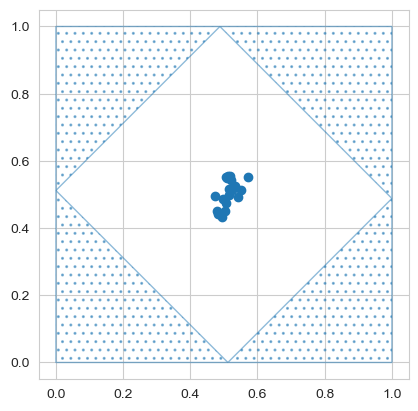

In [50]:
landmarks=helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

In [51]:
root="results_testing_saving/"
seed_ints = ["69904-149796","69904","149796"]
season_lens=[300,20_000,20_000]
rule = 30
rules = [f"{rule}-{rule}", rule, rule]
num_repeats = 2
pop_size = 1000

all_fits = []
for g in range(len(season_lens)):
    fits=[np.loadtxt(os.path.expanduser(root+f"stats_{season_lens[g]}_{rules[g]}_{seed_ints[g]}_{i+1}_both_fits.txt")) for i in range(num_repeats)]
    fits = np.array(fits)
    num_gens = int(fits.shape[1]/2/pop_size)
    fits = fits.reshape(num_repeats, num_gens, 2, pop_size)
    all_fits.append(fits)
all_fits=np.vstack(all_fits)
all_fits=np.reshape(all_fits, (3, num_repeats, num_gens, 2, pop_size ))
all_fits.shape

(3, 2, 2000, 2, 1000)

In [54]:
import math
#ITT TARTOK, FINISH BELOW FUNCTION. prop_distance_best, prop_distance_line should be good, need to combine.
def calc_conz_BH(fitness1, fitness2, landmarks):
    bestgen=landmarks.iloc[2]
    distance_best=helper.calculate_distance(fitness1, fitness2, bestgen[0], bestgen[1]) #want this to be small
    max_distance_best = helper.calculate_distance(bestgen[0], bestgen[1], landmarks.iloc[5][0],landmarks.iloc[5][1]) #bottom left corner
    prop_distance_best = 1 - distance_best/max_distance_best 
    
    #distance_line = abs(fitness1-fitness2) #want this to be small
    distance_line = abs(fitness1 - fitness2) / math.sqrt(2)
    max_distance_line = helper.calculate_distance(bestgen[0], bestgen[1], landmarks.iloc[0][0],landmarks.iloc[0][1]) #top right corner
    prop_distance_line = 1 - distance_line/max_distance_line

    print(prop_distance_best, prop_distance_line)

p2=[0.488142, 0.9]
calc_conz_BH(p2[0], p2[1], landmarks)

0.6155193042046816 0.19536622393822412


/var/folders/41/13rhly317ygcfk0c_1jggxch0000gn/T/ipykernel_13437/3348285766.py:4: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  distance_best=helper.calculate_distance(fitness1, fitness2, bestgen[0], bestgen[1]) #want this to be small
/var/folders/41/13rhly317ygcfk0c_1jggxch0000gn/T/ipykernel_13437/3348285766.py:5: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  max_distance_best = helper.calculate_distance(bestgen[0], bestgen[1], landmarks.iloc[5][0],landmarks.iloc[5][1]) #bottom left corner
/var/folders/41/13rhly317ygcfk0c_1jggxch0000gn/T/ipykernel_13437/3348285766.py:10: FutureWarning: Series.__getitem__ treating ke

0.18096913140232146
0.1809691314023215
0.6161066462450384 0.6161065731225297


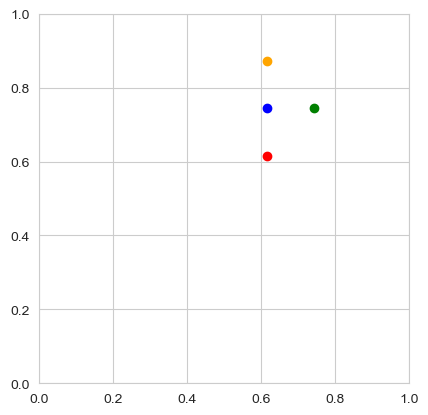

In [31]:
import math
p1=[bestgen, bestgen]
p2=[0.488142, 1.000000]
midpoint = ((p1[0] + p2[0]) / 2, (p1[1] + p2[1]) / 2)

distance=helper.calculate_distance(p1[0], p1[1], midpoint[0], midpoint[1])
print(distance)
new_x = p1[0] - distance / math.sqrt(2)
new_y = p1[1] - distance / math.sqrt(2)
distance=helper.calculate_distance(p1[0], p1[1], new_x, new_y)
print(distance)
print(new_x, midpoint[0])

plt.xlim(0,1)
plt.ylim(0,1)
plt.scatter(p1[0],p1[1], color="green")
plt.scatter(midpoint[0],midpoint[1], color="orange")
plt.scatter(new_x,new_y,color="red")
plt.scatter(new_x, p1[1], color="blue")
plt.gca().set_aspect('equal', adjustable='box')

#NOTE: I want a generalist calculator where the midpoint (yellow) has a pretty bad score,
# the red one on the diagonal has a better score (eventhough same distance from green)
# and the blue has exactly and inbetween score
# so we can have a distance from green + distance from line, balanced

299


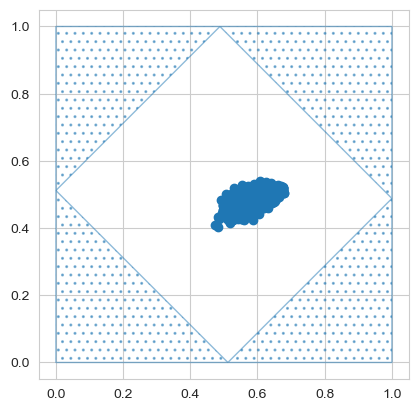

599


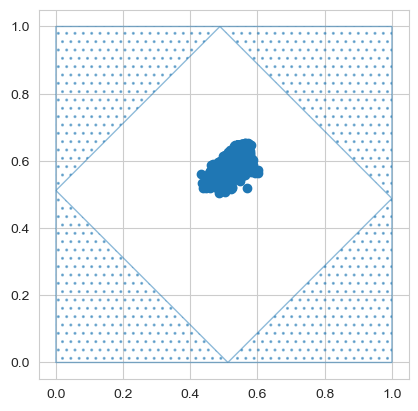

899


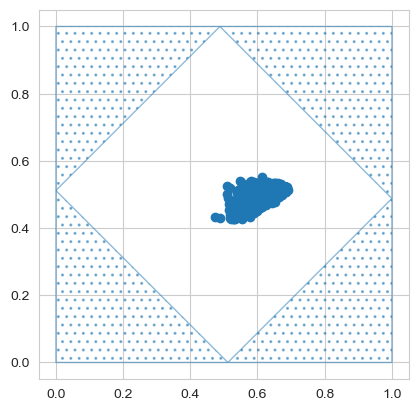

1199


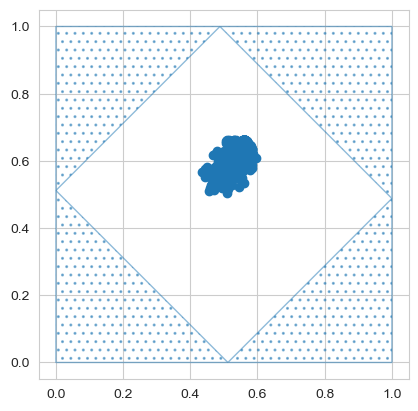

1499


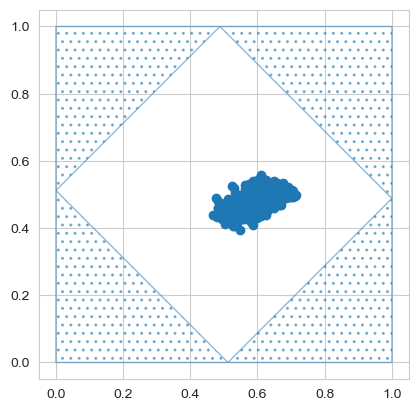

1799


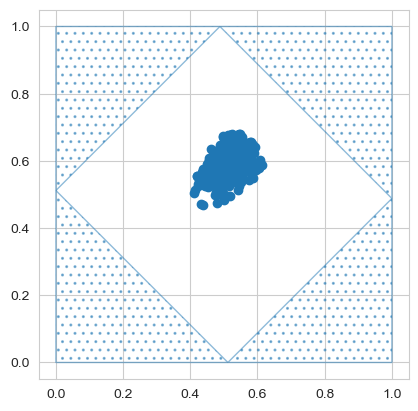

In [31]:
#NOTE: for static envs, fitnesses 1 is always the env they were evaluated on 
# (as opposed to fitnesses 2 being the relevant one when testing environment 1)

repid=1
a=list(range(2000))
check_freq=300
int_gens=a[check_freq-1::check_freq]

for i in int_gens:
    print(i)
    fitnesses1=all_fits[0][repid][i][0]
    fitnesses2=all_fits[0][repid][i][1]

    helper.make_restricted_plot(all_targs, num_cells, dev_steps, fitnesses1, fitnesses2, labelled=False)

#0.77429666 0.68433944 env 1
#0.67506982 0.73483343 env 2
#0.73658872 0.68701547